## General Info

This notebook presents an analysis of machine learning models trained to predict
heart disease using three different data preprocessing approaches. The quality of the model was evaluated on a deferred sample.
Based on this analysis, the best-performing model and preprocessing pipeline
for the task are identified.

## Table of contents

1. [General Info](#general-Info)
2. [Dataset & Preprocessing](#Dataset-&-Preprocessing)
3. [Evaluation Metrics](#Evaluation-Metrics)
4. [Results](#Results)
   - [Imports & Settings](#Imports-&-Settings)
   - [Metrics Tables](#Metrics-Tables)
   - [Confusion Matrices](#Confusion-Matrices)
   - [Bar Plot Comparison](#Bar-Plot-Comparison)
   - [Curve Analysis](#Curve-Analysis)
     - [ROC Curve](#ROC-Curve)
     - [PR Curve](#PR-Curve)
5. [Summary](#Summary)

## Dataset & Preprocessing

The dataset was previously analyzed in the exploratory data analysis (EDA) notebook.
Three preprocessing pipelines were used in this project:

**Simple pipeline**

Contains minimal processing steps:

- Rows with missing values are removed
- Outliers are filtered using a predefined threshold
- No feature scaling
- One-Hot Encoding using Pandas

**Standard pipeline**

Includes common preprocessing steps:

- Missing values are replaced with mean (for numerical) or mode (for categorical) 
- Outliers are removed based on percentiles
- One-Hot Encoding using Scikit-Learn
- Feature scaling with StandardScaler

**Advanced pipeline**

Applies more sophisticated preprocessing:

- Categorical values are encoded by frequency
- Missing values are imputed using KNNImputer
- Feature scaling with RobustScaler
- Outliers are removed using IsolationForest

Each pipeline produces a separate train-test split and corresponding trained models.

## Evaluation Metrics

The following metrics are used to evaluate models:

- **Accuracy** - the percentage of correct predictions among all samples. It provides a general overview of model performance and is suitable here because the dataset is relatively balanced.

- **Precision**: the percentage of correct patient predictions among all patients marked as sick by the model.  
- **Recall**: the percentage of correct patient predictions among all truly sick patients. This metric is particularly important in the context of disease detection, as missing a positive case (false negative) carries a higher cost.
- **F-1** 
- **ROC-AUC**
- **PR-AUC** - area under the Precision-Recall curve, estimated using the Average Precision (AP) score in this analysis.

These metrics provide both a **threshold-dependent evaluation** (Accuracy, Precision, Recall,  F1, Confusion Matrix) and **threshold-independent evaluation** (ROC-AUC, PR-AUC), giving a comprehensive overview of model performance.

- All metrics values can be found in the [Metrics Tables](#Metrics-Tables) section.
- Confusion Matrices are shown in [Confusion Matrices](#Confusion-Matrices).
- ROC-AUC and PR-AUC curves are visualized in [Curve Analysis](#Curve-Analysis).

## Results

#### Imports & Settings

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
results_dir = Path("../results")
splits_dir = Path("../data/splits")
preprocessing_types = ['simple', 'standard', 'advanced']

#### Metrics Tables

In [21]:
simple_metrics = pd.read_csv(results_dir / 'simple_metrics.csv')
standard_metrics = pd.read_csv(results_dir / 'standard_metrics.csv')
advanced_metrics = pd.read_csv(results_dir / 'advanced_metrics.csv')

print(f'Simple: \n{simple_metrics}\n'
      f'\nStandard: \n{standard_metrics}\n'
      f'\nAdvanced: \n{advanced_metrics}\n')

Simple: 
  model  accuracy  precision    recall        f1   roc_auc
0   Ada  0.860360   0.844037  0.867925  0.855814  0.934613
1    GB  0.855856   0.836364  0.867925  0.851852  0.932498
2   KNN  0.693694   0.658333  0.745283  0.699115  0.767689
3    LR  0.869369   0.853211  0.877358  0.865116  0.931522
4    RF  0.860360   0.826087  0.896226  0.859729  0.938191
5   SVM  0.860360   0.826087  0.896226  0.859729  0.925098

Standard: 
  model  accuracy  precision    recall        f1   roc_auc
0   Ada  0.843602   0.817308  0.858586  0.837438  0.910038
1    GB  0.819905   0.827957  0.777778  0.802083  0.907287
2   KNN  0.853081   0.826923  0.868687  0.847291  0.917118
3    LR  0.876777   0.876289  0.858586  0.867347  0.931006
4    RF  0.862559   0.850000  0.858586  0.854271  0.920094
5   SVM  0.838863   0.828283  0.828283  0.828283  0.919282

Advanced: 
  model  accuracy  precision    recall        f1   roc_auc
0   Ada  0.860870   0.907407  0.816667  0.859649  0.935341
1    GB  0.856522   0.8

#### Confusion Matrices

<Figure size 800x600 with 0 Axes>

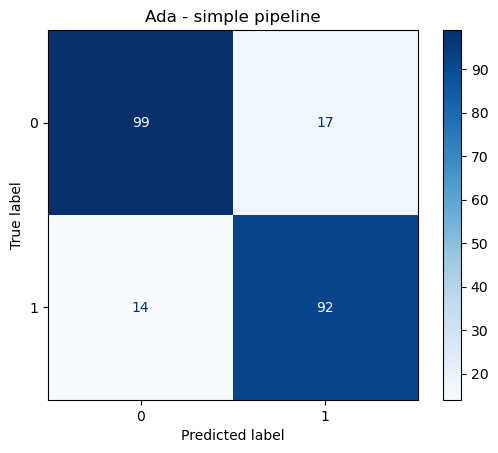

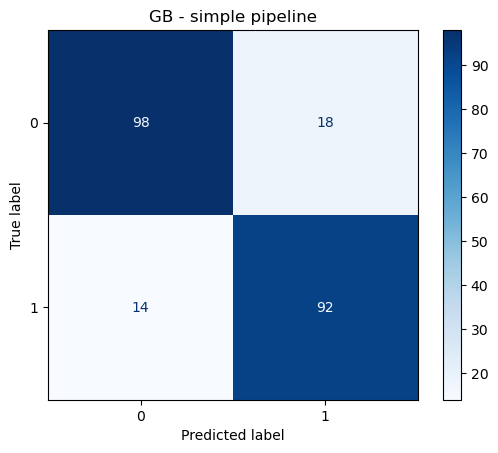

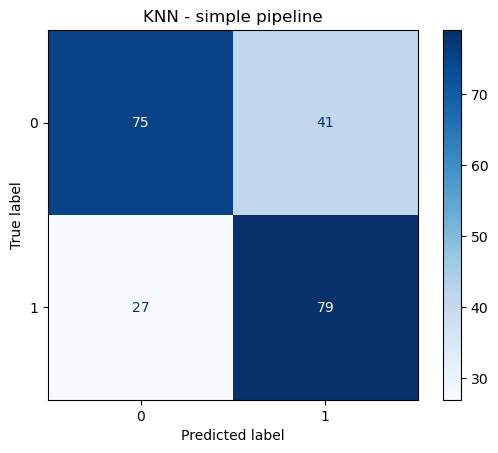

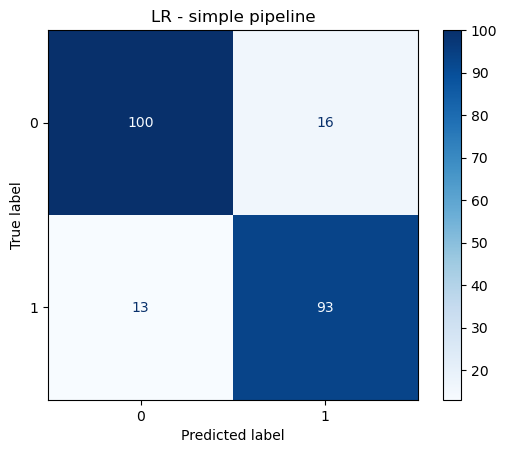

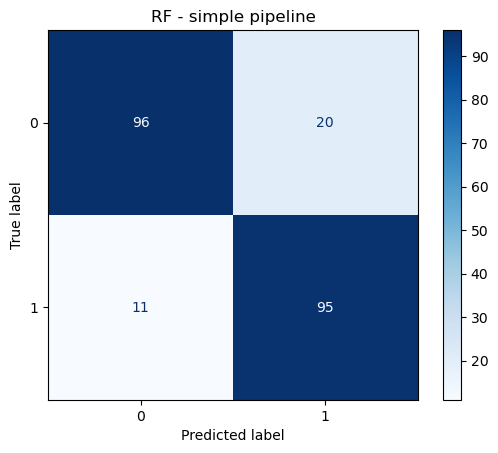

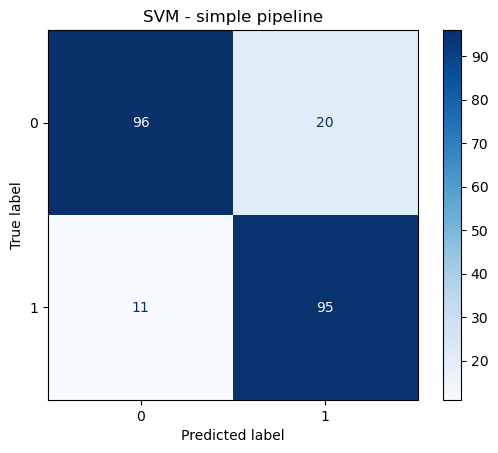

<Figure size 800x600 with 0 Axes>

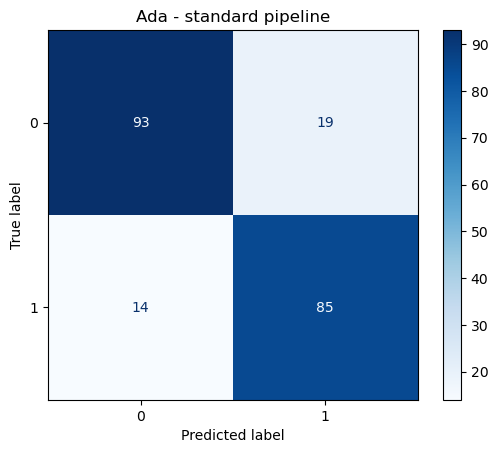

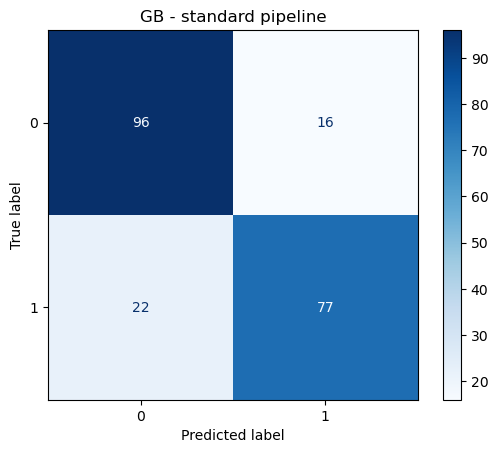

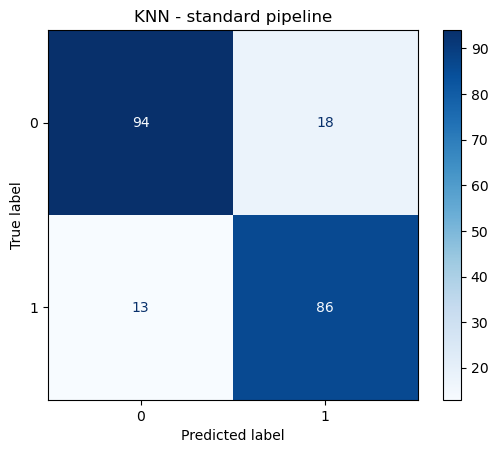

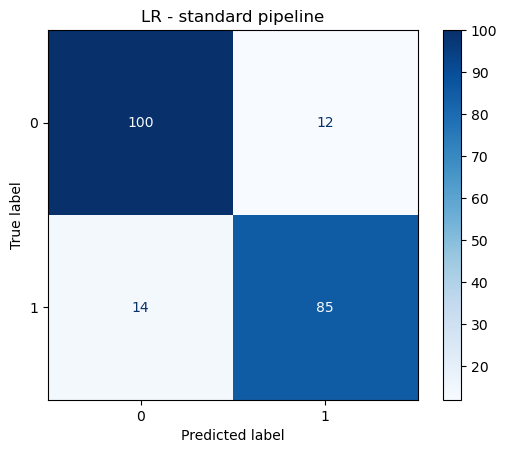

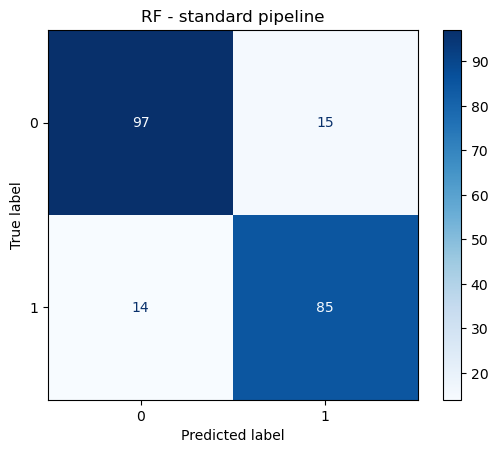

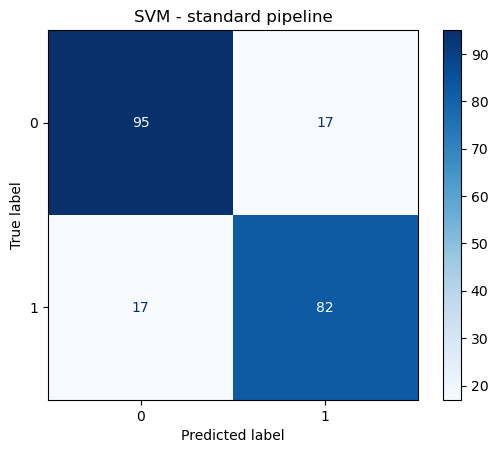

<Figure size 800x600 with 0 Axes>

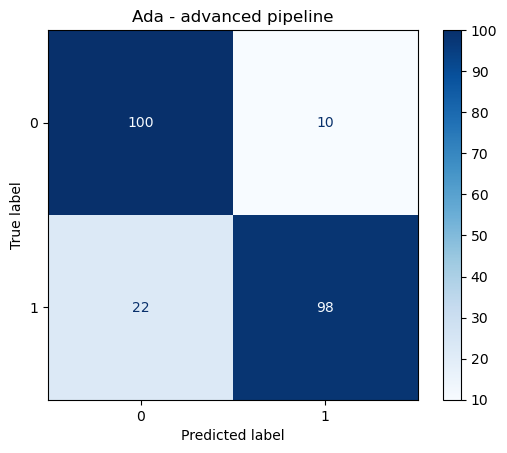

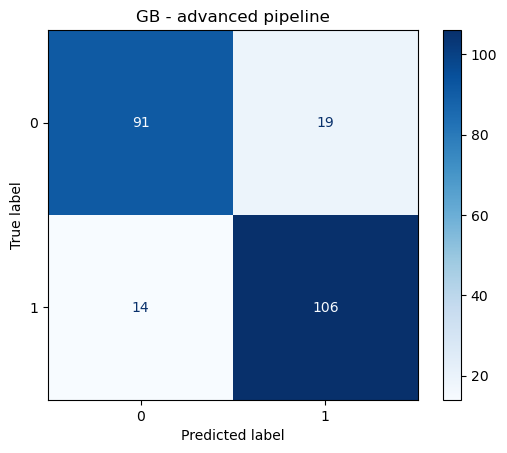

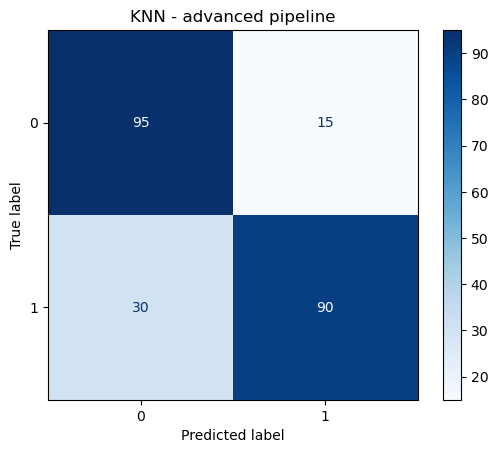

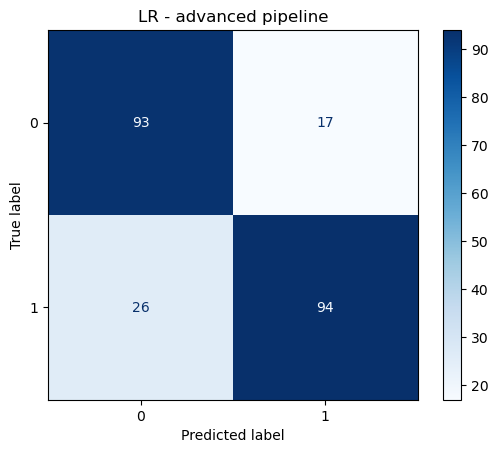

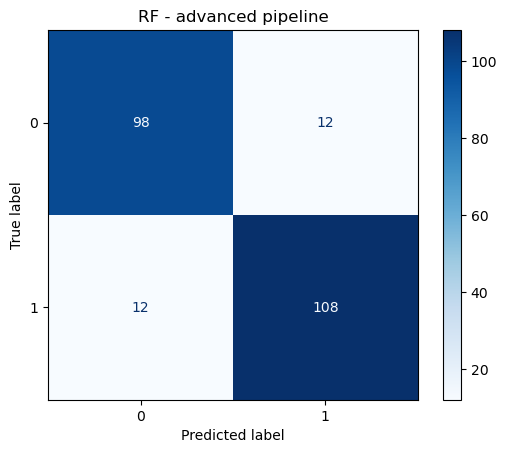

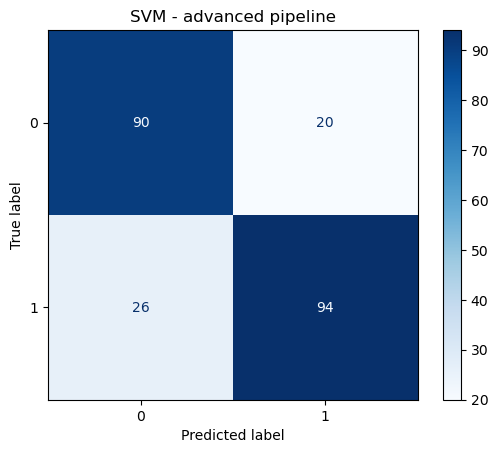

In [22]:
for prep in preprocessing_types:
    predict_file = Path(results_dir / f'{prep}_y_predict.npy')
    y_predictions = np.load(predict_file, allow_pickle=True).item()  # это словарь: model_name -> y_pred
    y_test = pd.read_csv(splits_dir / f'{prep}_y_test.csv').values.ravel()

    plt.figure(figsize=(8,6))
    
    for model_name, y_pred in y_predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} - {prep} pipeline")
        plt.show()

#### Bar Plot Comparison

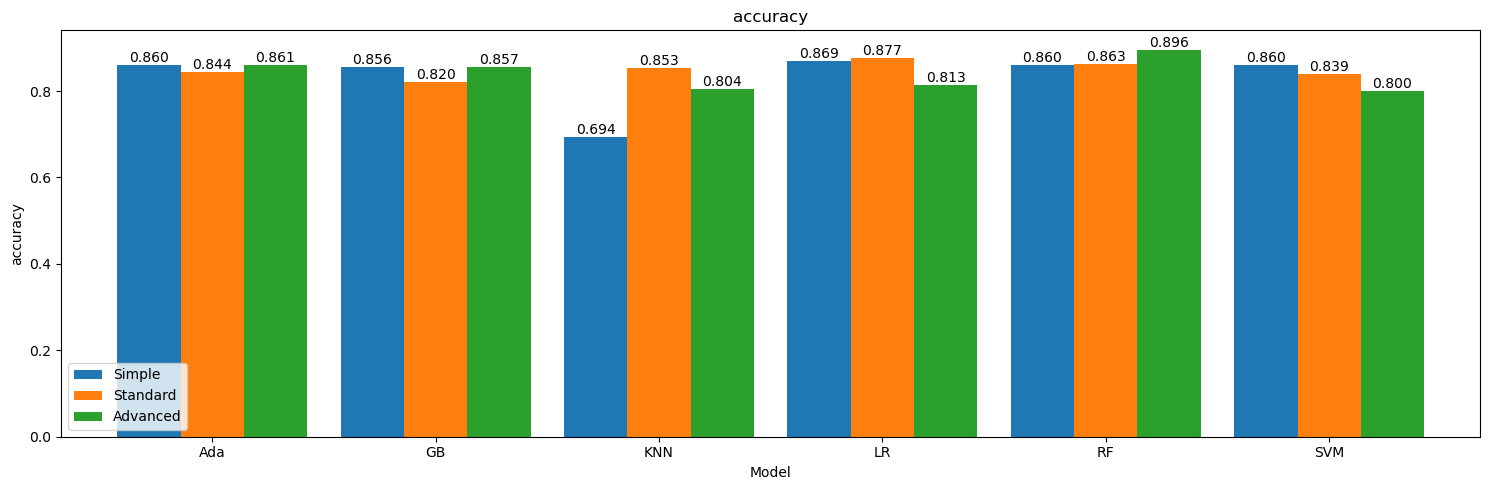

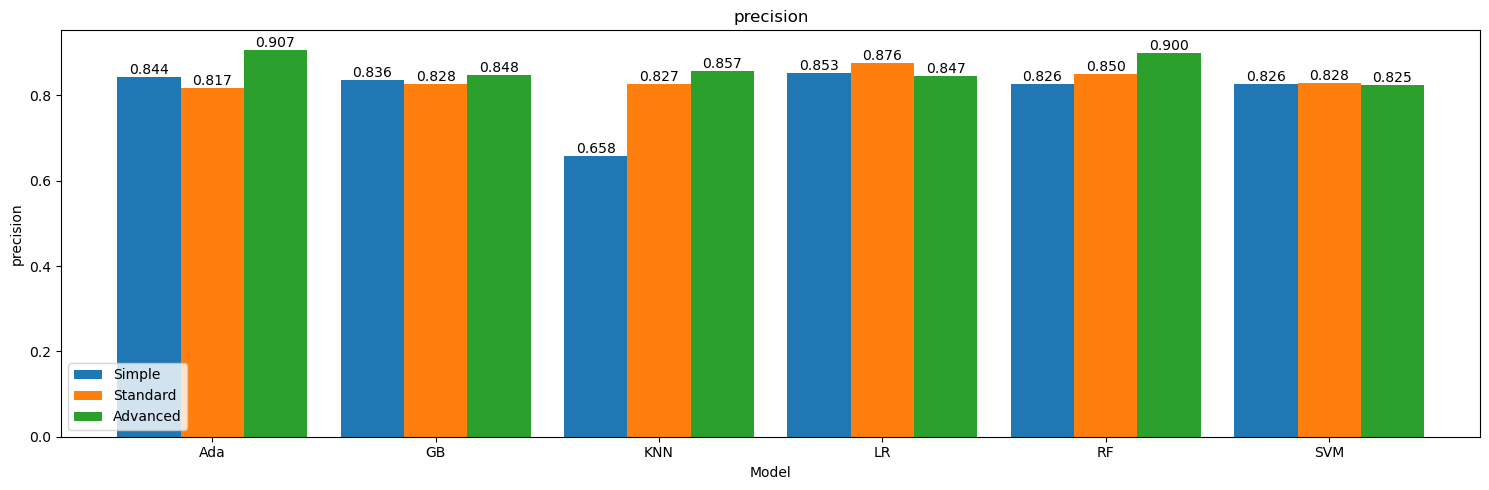

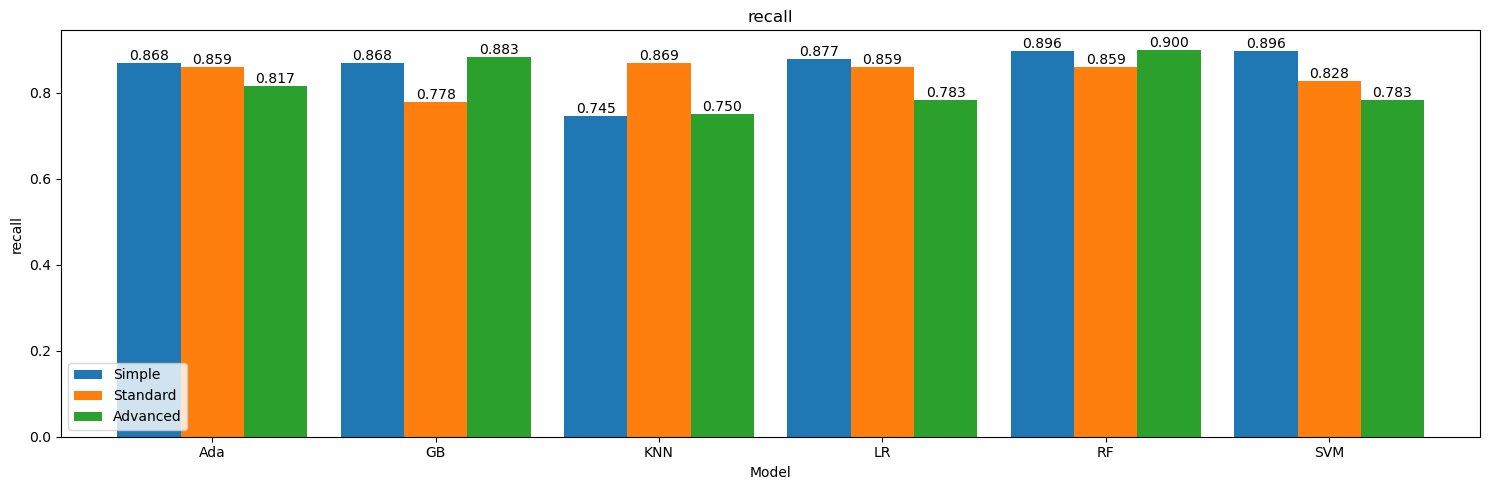

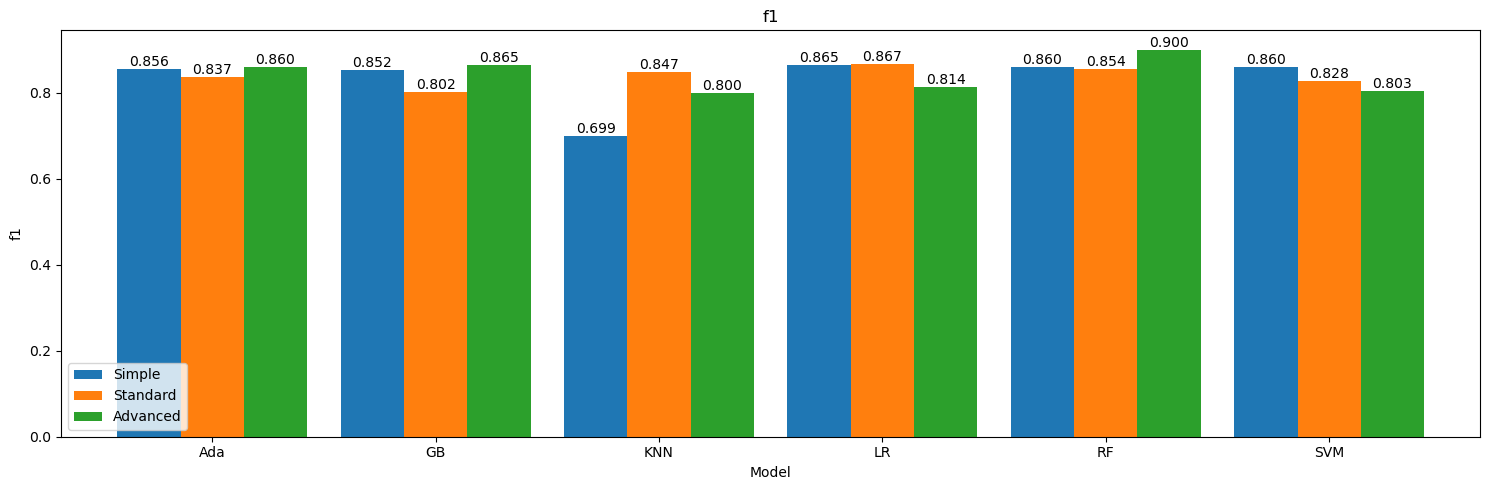

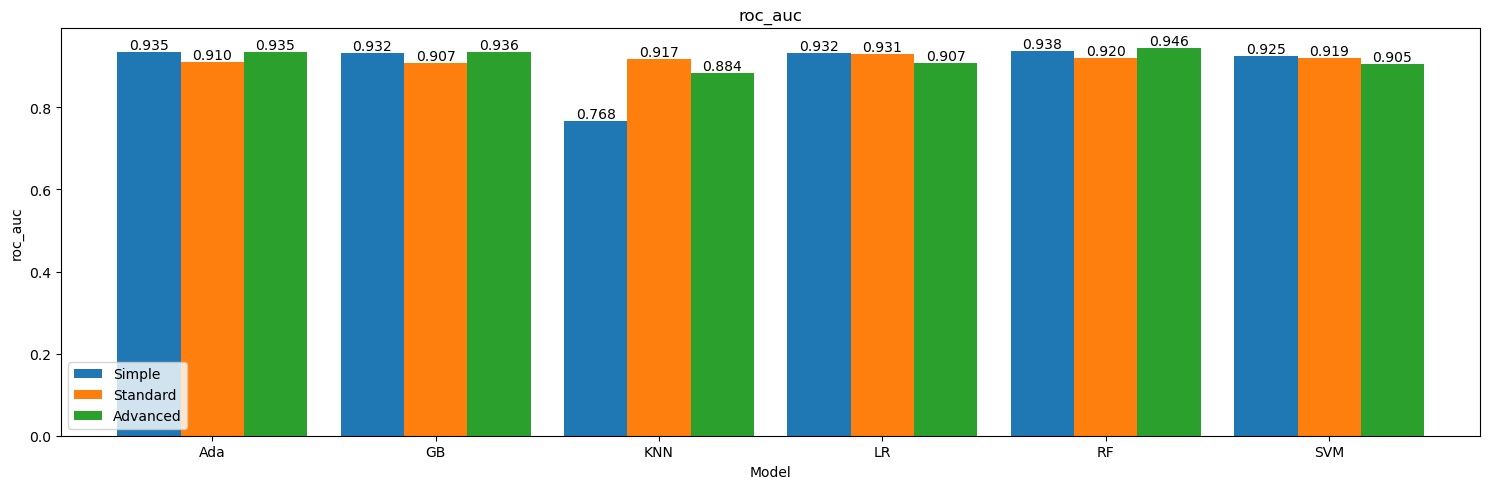

In [23]:
metrics = simple_metrics.columns.drop('model')

for metric in metrics:
    comparison = pd.DataFrame({
        'Model': simple_metrics['model'],
        'Simple': simple_metrics[metric],
        'Standard': standard_metrics[metric],
        'Advanced': advanced_metrics[metric]
    })
    comparison.set_index('Model', inplace=True)
    
    ax = comparison.plot(
        kind='bar',
        figsize=(15, 5),
        title=metric,
        width=0.85
    )
    ax.set_ylabel(metric)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

#### Curve Analysis

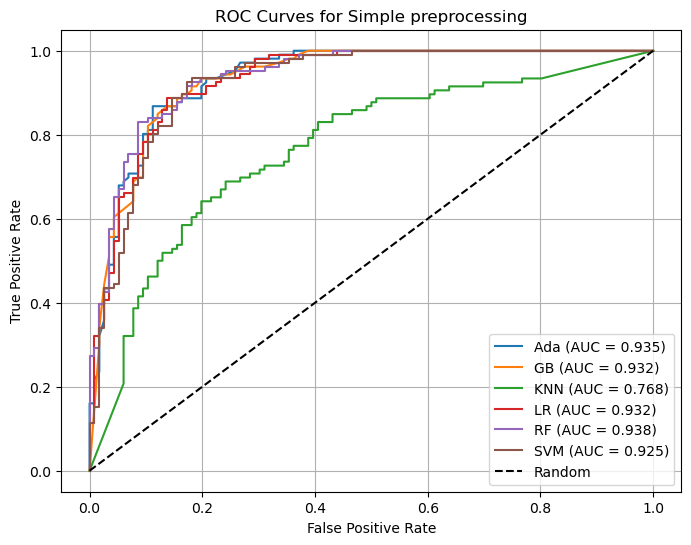

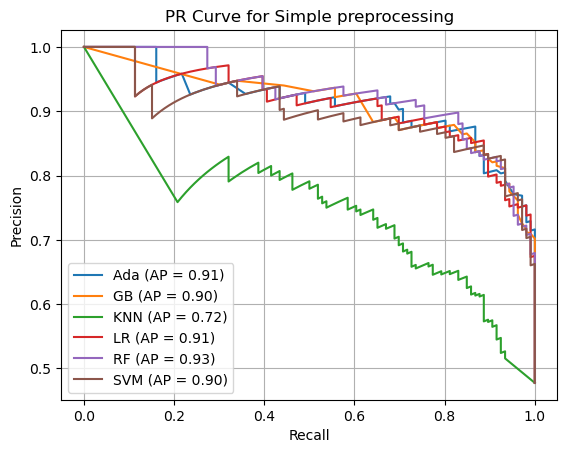

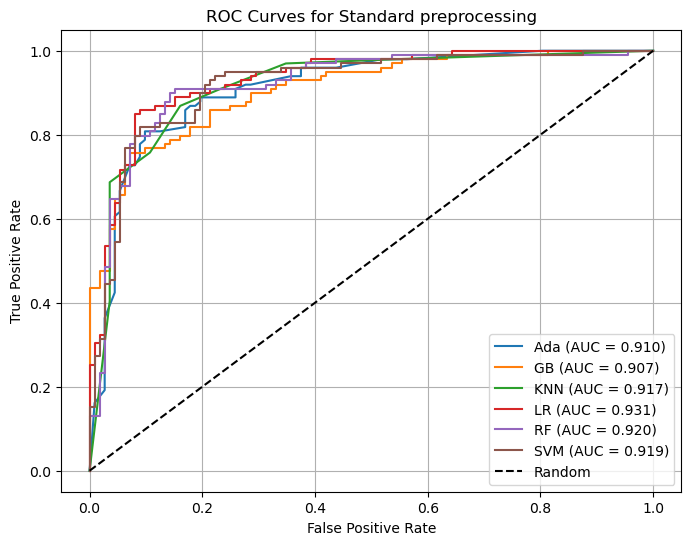

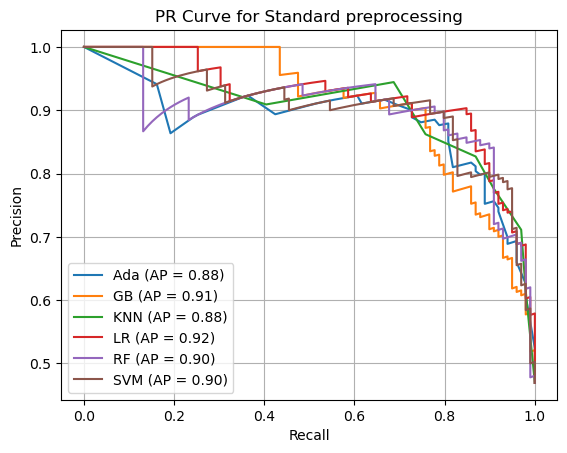

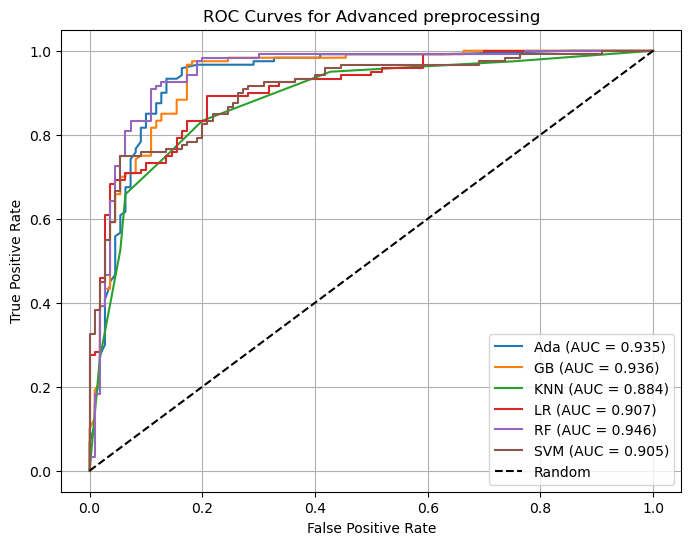

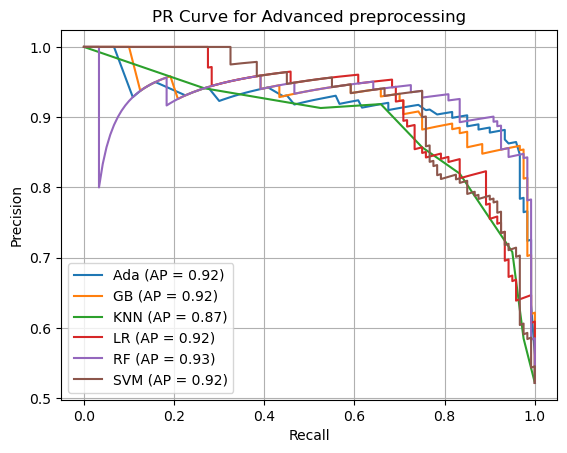

In [24]:
for prep in preprocessing_types:
    score_file = Path(results_dir / f'{prep}_y_scores.npy')

    y_scores = np.load(score_file, allow_pickle=True).item()
    y_test = pd.read_csv(splits_dir / f'{prep}_y_test.csv').values.ravel()

    plt.figure(figsize=(8,6))

    for model_name, y_score in y_scores.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

    plt.plot([0,1], [0,1], 'k--', label="Random")

    plt.title(f"ROC Curves for {prep.capitalize()} preprocessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    for model_name, y_score in y_scores.items():
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f"{model_name} (AP = {ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve for {prep.capitalize()} preprocessing")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

##### ROC Curve

##### PR Curve

## Summary